In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde, chi2
import pymc3 as pm
import theano.tensor as tt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep', 'arviz-colors', 'arviz-white', 'arviz-whitegrid', 'arviz-darkgrid']


In [2]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=10000 # length of data set
P=500 # range to fit acf

In [4]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
    else:
        acf_all = np.vstack((acf_all, y))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<ErrorbarContainer object of 3 artists>

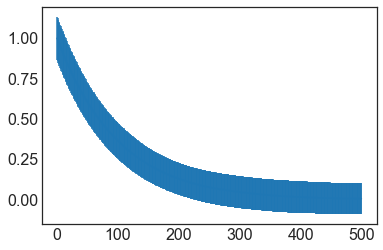

In [5]:
plt.errorbar(t,acf_mean,yerr=acf_std)

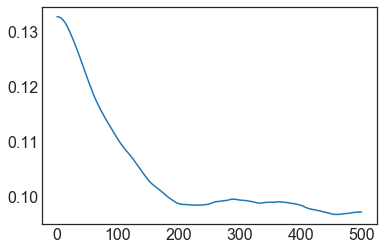

In [6]:
plt.plot(t,acf_std)

In [7]:
acf_all[0].size

500

In [8]:
mod = ExponentialModel()
result_array = None
for i,y in enumerate(acf_all):
    print("***** Iteration ",i," *****")
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = None
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            out.covar[0,0],
                            out.values['amplitude'],
                            out.covar[1,1],
                            out.covar[0,1],
                              out.chisqr])
        print(out.fit_report(min_correl=0.25))
        
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out2 = mod.fit(y, pars, x=t, weights=1/acf_std)
    except:
        fit_std_results = None
        print('fit did not work weights')
    else:
        fit_std_results = np.array([out2.values['decay']*delta_t,
                            out2.covar[0,0],
                            out2.values['amplitude'],
                            out2.covar[1,1],
                            out2.covar[0,1],
                            out2.chisqr])
        print(out2.fit_report(min_correl=0.25))
    
    if (fit_results is None) or (fit_std_results is None):
        continue
        
    results = np.concatenate((fit_results, fit_std_results))

    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))


***** Iteration  0  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.37953197
    reduced chi-square = 7.6211e-04
    Akaike info crit   = -3587.71227
    Bayesian info crit = -3579.28305
[[Variables]]
    amplitude:  0.80861570 +/- 0.00548762 (0.68%) (init = 1)
    decay:      99.3941865 +/- 0.96000784 (0.97%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 36.8918773
    reduced chi-square = 0.07408007
    Akaike info crit   = -1299.30835
    Bayesian info crit = -1290.87913
[[Variables]]
    amplitude:  0.79842691 +/- 0.00669524 (0.84%) (init = 1)
    decay:      101.268683 +/- 1.05611196 (

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 155.942164
    reduced chi-square = 0.31313688
    Akaike info crit   = -578.561452
    Bayesian info crit = -570.132236
[[Variables]]
    amplitude:  0.93003388 +/- 0.01013285 (1.09%) (init = 1)
    decay:      187.855588 +/- 2.69312594 (1.43%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.756
***** Iteration  14  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 0.55447745
    reduced chi-square = 0.00111341
    Akaike info crit   = -3398.16862
    Bayesian info crit = -3389.73941
[[Variables]]
    amplitude:  0.75978277 +/- 0.00537198 (0.71%) (init = 1)
    decay:      156.475374 +/- 1.60634746 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 84.2344506
    reduced chi-square = 0.16914548
    Akaike info crit   = -886.502054
    Bayesian info crit = -878.072838
[[Variables]]
    amplitude:  1.27250050 +/- 0.01016278 (0.80%) (init = 1)
    decay:      100.397874 +/- 0.99728756 (0.99%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.722
***** Iteration  29  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.50323777
    reduced chi-square = 0.00101052
    Akaike info crit   = -3446.65031
    Bayesian info crit = -3438.22109
[[Variables]]
    amplitude:  0.89560519 +/- 0.00673196 (0.75%) (init = 1)
    decay:      87.2221101 +/- 0.93297412 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 605.870459
    reduced chi-square = 1.21660735
    Akaike info crit   = 100.029051
    Bayesian info crit = 108.458267
[[Variables]]
    amplitude:  1.09304137 +/- 0.03484598 (3.19%) (init = 1)
    decay:      62.8225780 +/- 2.54796008 (4.06%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.708
***** Iteration  46  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 2.45326456
    reduced chi-square = 0.00492623
    Akaike info crit   = -2654.59424
    Bayesian info crit = -2646.16503
[[Variables]]
    amplitude:  1.03311116 +/- 0.01486562 (1.44%) (init = 1)
    decay:      87.2015590 +/- 1.78548321 (2

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 2.37385368
    reduced chi-square = 0.00476677
    Akaike info crit   = -2671.04672
    Bayesian info crit = -2662.61750
[[Variables]]
    amplitude:  1.23776711 +/- 0.01610512 (1.30%) (init = 1)
    decay:      71.5057290 +/- 1.32481870 (1.85%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 229.041851
    reduced chi-square = 0.45992339
    Akaike info crit   = -386.351679
    Bayesian info crit = -377.922463
[[Variables]]
    amplitude:  1.26362269 +/- 0.02040660 (1.61%) (init = 1)
    decay:      68.9612324 +/- 1.40810257 (2.04%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 29.1722565
    reduced chi-square = 0.05857883
    Akaike info crit   = -1416.69498
    Bayesian info crit = -1408.26576
[[Variables]]
    amplitude:  0.82737630 +/- 0.00452186 (0.55%) (init = 1)
    decay:      175.371922 +/- 1.24291950 (0.71%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.751
***** Iteration  82  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 2.66664972
    reduced chi-square = 0.00535472
    Akaike info crit   = -2612.89260
    Bayesian info crit = -2604.46338
[[Variables]]
    amplitude:  1.14887271 +/- 0.01822630 (1.59%) (init = 1)
    decay:      62.4516541 +/- 1.41254836 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.33157607
    reduced chi-square = 6.6582e-04
    Akaike info crit   = -3655.25307
    Bayesian info crit = -3646.82385
[[Variables]]
    amplitude:  0.89462463 +/- 0.00565887 (0.63%) (init = 1)
    decay:      81.1735343 +/- 0.73077857 (0.90%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 31.1455771
    reduced chi-square = 0.06254132
    Akaike info crit   = -1383.96793
    Bayesian info crit = -1375.53871
[[Variables]]
    amplitude:  0.87969125 +/- 0.00681498 (0.77%) (init = 1)
    decay:      83.3206692 +/- 0.80749041 (0.97%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 77
    # data points      = 500
    # variables        = 2
    chi-square         = 802.646571
    reduced chi-square = 1.61174010
    Akaike info crit   = 240.653191
    Bayesian info crit = 249.082407
[[Variables]]
    amplitude:  1.21429174 +/- 0.03927603 (3.23%) (init = 1)
    decay:      65.4056225 +/- 2.68338386 (4.10%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.709
***** Iteration  116  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 2.58312025
    reduced chi-square = 0.00518699
    Akaike info crit   = -2628.80502
    Bayesian info crit = -2620.37580
[[Variables]]
    amplitude:  1.31462465 +/- 0.01308770 (1.00%) (init = 1)
    decay:      119.908076 +/- 1.70433089 (

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 500
    # variables        = 2
    chi-square         = 393.387643
    reduced chi-square = 0.78993503
    Akaike info crit   = -115.906302
    Bayesian info crit = -107.477086
[[Variables]]
    amplitude:  1.31545634 +/- 0.02837307 (2.16%) (init = 1)
    decay:      61.5729507 +/- 1.69214138 (2.75%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.707
***** Iteration  134  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.64326192
    reduced chi-square = 0.00329972
    Akaike info crit   = -2854.96243
    Bayesian info crit = -2846.53321
[[Variables]]
    amplitude:  0.90412673 +/- 0.00977822 (1.08%) (init = 1)
    decay:      138.071712 +/- 2.14535911

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 0.98172509
    reduced chi-square = 0.00197134
    Akaike info crit   = -3112.52603
    Bayesian info crit = -3104.09681
[[Variables]]
    amplitude:  1.06946087 +/- 0.01106881 (1.03%) (init = 1)
    decay:      62.3388309 +/- 0.91981105 (1.48%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.701
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 91.7026138
    reduced chi-square = 0.18414179
    Akaike info crit   = -844.028608
    Bayesian info crit = -835.599392
[[Variables]]
    amplitude:  1.08890626 +/- 0.01384361 (1.27%) (init = 1)
    decay:      60.3365227 +/- 0.97893797 (1.62%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 102.934327
    reduced chi-square = 0.20669544
    Akaike info crit   = -786.258459
    Bayesian info crit = -777.829243
[[Variables]]
    amplitude:  1.10715973 +/- 0.01117868 (1.01%) (init = 1)
    decay:      101.349808 +/- 1.27271914 (1.26%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.722
***** Iteration  168  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.13981297
    reduced chi-square = 0.00228878
    Akaike info crit   = -3037.87196
    Bayesian info crit = -3029.44274
[[Variables]]
    amplitude:  0.69878934 +/- 0.00914702 (1.31%) (init = 1)
    decay:      107.769320 +/- 2.00902789

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 319.772111
    reduced chi-square = 0.64211267
    Akaike info crit   = -219.499754
    Bayesian info crit = -211.070538
[[Variables]]
    amplitude:  0.83347392 +/- 0.01111670 (1.33%) (init = 1)
    decay:      389.968388 +/- 9.41003146 (2.41%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.812
***** Iteration  186  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.62741297
    reduced chi-square = 0.00125987
    Akaike info crit   = -3336.37921
    Bayesian info crit = -3327.94999
[[Variables]]
    amplitude:  0.87866343 +/- 0.00614752 (0.70%) (init = 1)
    decay:      132.945871 +/- 1.33340091

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.71252561
    reduced chi-square = 0.00143077
    Akaike info crit   = -3272.77376
    Bayesian info crit = -3264.34454
[[Variables]]
    amplitude:  0.76190204 +/- 0.00829595 (1.09%) (init = 1)
    decay:      81.1701433 +/- 1.25770412 (1.55%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 71.2160827
    reduced chi-square = 0.14300418
    Akaike info crit   = -970.444713
    Bayesian info crit = -962.015497
[[Variables]]
    amplitude:  0.76683352 +/- 0.01047947 (1.37%) (init = 1)
    decay:      80.7015494 +/- 1.38173135 (1.71%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 104.334931
    reduced chi-square = 0.20950789
    Akaike info crit   = -779.500941
    Bayesian info crit = -771.071725
[[Variables]]
    amplitude:  0.64703203 +/- 0.01072724 (1.66%) (init = 1)
    decay:      111.115925 +/- 2.29066308 (2.06%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.726
***** Iteration  220  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.96879893
    reduced chi-square = 0.00194538
    Akaike info crit   = -3119.15315
    Bayesian info crit = -3110.72393
[[Variables]]
    amplitude:  1.01485078 +/- 0.00807091 (0.80%) (init = 1)
    decay:      118.162175 +/- 1.34100943

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 295.461141
    reduced chi-square = 0.59329546
    Akaike info crit   = -259.035386
    Bayesian info crit = -250.606170
[[Variables]]
    amplitude:  0.89138134 +/- 0.01481267 (1.66%) (init = 1)
    decay:      164.873044 +/- 3.51375357 (2.13%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.747
***** Iteration  236  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 2.48809201
    reduced chi-square = 0.00499617
    Akaike info crit   = -2647.54597
    Bayesian info crit = -2639.11676
[[Variables]]
    amplitude:  1.04947682 +/- 0.01518196 (1.45%) (init = 1)
    decay:      84.7216479 +/- 1.74420383

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.92181991
    reduced chi-square = 0.00185104
    Akaike info crit   = -3144.00675
    Bayesian info crit = -3135.57753
[[Variables]]
    amplitude:  1.04032029 +/- 0.00928664 (0.89%) (init = 1)
    decay:      83.8775201 +/- 1.06538336 (1.27%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 89.2289788
    reduced chi-square = 0.17917466
    Akaike info crit   = -857.701119
    Bayesian info crit = -849.271902
[[Variables]]
    amplitude:  1.05671929 +/- 0.01163079 (1.10%) (init = 1)
    decay:      82.0194806 +/- 1.13013815 (1.38%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.30275076
    reduced chi-square = 6.0793e-04
    Akaike info crit   = -3700.72675
    Bayesian info crit = -3692.29753
[[Variables]]
    amplitude:  0.85047063 +/- 0.00586252 (0.69%) (init = 1)
    decay:      68.7376124 +/- 0.67498164 (0.98%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 29.2798542
    reduced chi-square = 0.05879489
    Akaike info crit   = -1414.85419
    Bayesian info crit = -1406.42498
[[Variables]]
    amplitude:  0.85626818 +/- 0.00735813 (0.86%) (init = 1)
    decay:      67.8566584 +/- 0.73802074 (1.09%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 1.94607419
    reduced chi-square = 0.00390778
    Akaike info crit   = -2770.39699
    Bayesian info crit = -2761.96778
[[Variables]]
    amplitude:  0.97163432 +/- 0.01070123 (1.10%) (init = 1)
    decay:      136.377103 +/- 2.15622480 (1.58%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.709
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 196.763965
    reduced chi-square = 0.39510836
    Akaike info crit   = -462.301619
    Bayesian info crit = -453.872402
[[Variables]]
    amplitude:  0.96978510 +/- 0.01321143 (1.36%) (init = 1)
    decay:      137.444500 +/- 2.34968965 (1.71%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 21.0772978
    reduced chi-square = 0.04232389
    Akaike info crit   = -1579.20579
    Bayesian info crit = -1570.77657
[[Variables]]
    amplitude:  1.09039201 +/- 0.00521055 (0.48%) (init = 1)
    decay:      95.7835202 +/- 0.56980689 (0.59%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.720
***** Iteration  307  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.35366168
    reduced chi-square = 0.00271820
    Akaike info crit   = -2951.89741
    Bayesian info crit = -2943.46819
[[Variables]]
    amplitude:  0.90325686 +/- 0.00941375 (1.04%) (init = 1)
    decay:      121.568010 +/- 1.80927268

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 3.51248247
    reduced chi-square = 0.00705318
    Akaike info crit   = -2475.14253
    Bayesian info crit = -2466.71331
[[Variables]]
    amplitude:  1.01397866 +/- 0.01633134 (1.61%) (init = 1)
    decay:      104.035813 +/- 2.38539440 (2.29%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.705
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 352.856091
    reduced chi-square = 0.70854637
    Akaike info crit   = -170.273899
    Bayesian info crit = -161.844683
[[Variables]]
    amplitude:  0.97315853 +/- 0.01983534 (2.04%) (init = 1)
    decay:      109.957070 +/- 2.78656418 (2.53%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 2.08891957
    reduced chi-square = 0.00419462
    Akaike info crit   = -2734.98056
    Bayesian info crit = -2726.55134
[[Variables]]
    amplitude:  1.00570870 +/- 0.01468109 (1.46%) (init = 1)
    decay:      75.8469101 +/- 1.57601878 (2.08%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 200.642768
    reduced chi-square = 0.40289713
    Akaike info crit   = -452.541022
    Bayesian info crit = -444.111805
[[Variables]]
    amplitude:  1.03327347 +/- 0.01856046 (1.80%) (init = 1)
    decay:      72.8493593 +/- 1.64853028 (2.26%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 131.295084
    reduced chi-square = 0.26364475
    Akaike info crit   = -664.580379
    Bayesian info crit = -656.151163
[[Variables]]
    amplitude:  0.94530118 +/- 0.01606152 (1.70%) (init = 1)
    decay:      64.0142606 +/- 1.38240605 (2.16%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.708
***** Iteration  360  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.99091763
    reduced chi-square = 0.00198979
    Akaike info crit   = -3107.86598
    Bayesian info crit = -3099.43677
[[Variables]]
    amplitude:  0.99748660 +/- 0.00994536 (1.00%) (init = 1)
    decay:      78.4741648 +/- 1.11357047

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 500
    # variables        = 2
    chi-square         = 481.302731
    reduced chi-square = 0.96647135
    Akaike info crit   = -15.0558236
    Bayesian info crit = -6.62660736
[[Variables]]
    amplitude:  1.24986602 +/- 0.03241190 (2.59%) (init = 1)
    decay:      57.8626599 +/- 1.92096423 (3.32%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.706
***** Iteration  376  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.13157635
    reduced chi-square = 2.6421e-04
    Akaike info crit   = -4117.38804
    Bayesian info crit = -4108.95882
[[Variables]]
    amplitude:  0.72401455 +/- 0.00256794 (0.35%) (init = 1)
    decay:      163.471712 +/- 0.84610897

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 64.3370297
    reduced chi-square = 0.12919082
    Akaike info crit   = -1021.23637
    Bayesian info crit = -1012.80716
[[Variables]]
    amplitude:  0.94859374 +/- 0.01112396 (1.17%) (init = 1)
    decay:      65.3416123 +/- 0.97240590 (1.49%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.709
***** Iteration  394  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.78657798
    reduced chi-square = 0.00358751
    Akaike info crit   = -2813.15303
    Bayesian info crit = -2804.72381
[[Variables]]
    amplitude:  1.11390634 +/- 0.01247554 (1.12%) (init = 1)
    decay:      90.2610328 +/- 1.43829559

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 3.30095943
    reduced chi-square = 0.00662843
    Akaike info crit   = -2506.19747
    Bayesian info crit = -2497.76825
[[Variables]]
    amplitude:  0.89860388 +/- 0.01985344 (2.21%) (init = 1)
    decay:      65.2386374 +/- 2.05454919 (3.15%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 340.415793
    reduced chi-square = 0.68356585
    Akaike info crit   = -188.220154
    Bayesian info crit = -179.790938
[[Variables]]
    amplitude:  0.90914880 +/- 0.02583855 (2.84%) (init = 1)
    decay:      64.1397824 +/- 2.31578456 (3.61%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.46723867
    reduced chi-square = 9.3823e-04
    Akaike info crit   = -3483.76159
    Bayesian info crit = -3475.33237
[[Variables]]
    amplitude:  1.16551469 +/- 0.00537369 (0.46%) (init = 1)
    decay:      129.290947 +/- 0.85343394 (0.66%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.708
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 48.6985239
    reduced chi-square = 0.09778820
    Akaike info crit   = -1160.47969
    Bayesian info crit = -1152.05047
[[Variables]]
    amplitude:  1.16673979 +/- 0.00678423 (0.58%) (init = 1)
    decay:      129.083175 +/- 0.93791684 (0.73%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 2.03380092
    reduced chi-square = 0.00408394
    Akaike info crit   = -2748.35084
    Bayesian info crit = -2739.92162
[[Variables]]
    amplitude:  1.07278559 +/- 0.01305231 (1.22%) (init = 1)
    decay:      93.9717607 +/- 1.62710025 (1.73%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 212.488479
    reduced chi-square = 0.42668369
    Akaike info crit   = -423.860163
    Bayesian info crit = -415.430947
[[Variables]]
    amplitude:  1.08442767 +/- 0.01683353 (1.55%) (init = 1)
    decay:      92.6748312 +/- 1.79230896 (1.93%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.23276176
    reduced chi-square = 4.6739e-04
    Akaike info crit   = -3832.17397
    Bayesian info crit = -3823.74475
[[Variables]]
    amplitude:  0.93013927 +/- 0.00383483 (0.41%) (init = 1)
    decay:      126.267656 +/- 0.74447338 (0.59%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.707
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 20.7497255
    reduced chi-square = 0.04166612
    Akaike info crit   = -1587.03754
    Bayesian info crit = -1578.60832
[[Variables]]
    amplitude:  0.91808375 +/- 0.00443910 (0.48%) (init = 1)
    decay:      128.476559 +/- 0.77601899 (0.60%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 4.55143632
    reduced chi-square = 0.00913943
    Akaike info crit   = -2345.58262
    Bayesian info crit = -2337.15340
[[Variables]]
    amplitude:  0.89322842 +/- 0.01195984 (1.34%) (init = 1)
    decay:      313.209170 +/- 7.39928177 (2.36%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.759
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 377.913699
    reduced chi-square = 0.75886285
    Akaike info crit   = -135.971119
    Bayesian info crit = -127.541903
[[Variables]]
    amplitude:  0.83251694 +/- 0.01248615 (1.50%) (init = 1)
    decay:      348.965230 +/- 8.86191239 (2.54%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 36.9758571
    reduced chi-square = 0.07424871
    Akaike info crit   = -1298.17145
    Bayesian info crit = -1289.74224
[[Variables]]
    amplitude:  0.69576616 +/- 0.00492138 (0.71%) (init = 1)
    decay:      188.937035 +/- 1.76097975 (0.93%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.756
***** Iteration  497  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.14612993
    reduced chi-square = 2.9343e-04
    Akaike info crit   = -4064.93361
    Bayesian info crit = -4056.50439
[[Variables]]
    amplitude:  0.90686676 +/- 0.00375498 (0.41%) (init = 1)
    decay:      81.2498180 +/- 0.47882318

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 109.942684
    reduced chi-square = 0.22076844
    Akaike info crit   = -753.324463
    Bayesian info crit = -744.895246
[[Variables]]
    amplitude:  1.21653798 +/- 0.01252756 (1.03%) (init = 1)
    decay:      86.8614031 +/- 1.11690667 (1.29%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.717
***** Iteration  514  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.38309460
    reduced chi-square = 0.00277730
    Akaike info crit   = -2941.14232
    Bayesian info crit = -2932.71311
[[Variables]]
    amplitude:  0.98916305 +/- 0.01266036 (1.28%) (init = 1)
    decay:      67.2885940 +/- 1.22714594

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 42.1990788
    reduced chi-square = 0.08473711
    Akaike info crit   = -1232.10485
    Bayesian info crit = -1223.67564
[[Variables]]
    amplitude:  1.06128912 +/- 0.00587724 (0.55%) (init = 1)
    decay:      149.040196 +/- 1.04393248 (0.70%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.741
***** Iteration  528  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 3.52465960
    reduced chi-square = 0.00707763
    Akaike info crit   = -2473.41212
    Bayesian info crit = -2464.98290
[[Variables]]
    amplitude:  0.70393686 +/- 0.01295950 (1.84%) (init = 1)
    decay:      173.573499 +/- 4.70098342

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.18445039
    reduced chi-square = 0.00237841
    Akaike info crit   = -3018.66462
    Bayesian info crit = -3010.23540
[[Variables]]
    amplitude:  0.89578482 +/- 0.00681080 (0.76%) (init = 1)
    decay:      223.246604 +/- 2.63564330 (1.18%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.733
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 94.9244147
    reduced chi-square = 0.19061127
    Akaike info crit   = -826.763579
    Bayesian info crit = -818.334363
[[Variables]]
    amplitude:  0.86627541 +/- 0.00720750 (0.83%) (init = 1)
    decay:      233.629327 +/- 2.72732792 (1.17%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 500
    # variables        = 2
    chi-square         = 14.8636559
    reduced chi-square = 0.02984670
    Akaike info crit   = -1753.84453
    Bayesian info crit = -1745.41532
[[Variables]]
    amplitude:  1.12839543 +/- 0.03775472 (3.35%) (init = 1)
    decay:      81.7861296 +/- 3.89277605 (4.76%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 500
    # variables        = 2
    chi-square         = 1521.12425
    reduced chi-square = 3.05446636
    Akaike info crit   = 560.298440
    Bayesian info crit = 568.727656
[[Variables]]
    amplitude:  1.16354270 +/- 0.04901193 (4.21%) (init = 1)
    decay:      78.9103182 +/- 4.16790833 (5.28%) (init = 100)
[[Correl

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 152.875802
    reduced chi-square = 0.30697952
    Akaike info crit   = -588.491130
    Bayesian info crit = -580.061914
[[Variables]]
    amplitude:  1.20554215 +/- 0.01482421 (1.23%) (init = 1)
    decay:      86.2840716 +/- 1.32523443 (1.54%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.717
***** Iteration  577  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 2.23647967
    reduced chi-square = 0.00449092
    Akaike info crit   = -2700.85252
    Bayesian info crit = -2692.42331
[[Variables]]
    amplitude:  0.97440210 +/- 0.01617806 (1.66%) (init = 1)
    decay:      66.6246996 +/- 1.57582539

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.24264574
    reduced chi-square = 4.8724e-04
    Akaike info crit   = -3811.38042
    Bayesian info crit = -3802.95120
[[Variables]]
    amplitude:  0.93285346 +/- 0.00405352 (0.43%) (init = 1)
    decay:      117.284318 +/- 0.72706242 (0.62%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.706
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 21.9417779
    reduced chi-square = 0.04405979
    Akaike info crit   = -1559.10781
    Bayesian info crit = -1550.67859
[[Variables]]
    amplitude:  0.92266631 +/- 0.00474219 (0.51%) (init = 1)
    decay:      119.264378 +/- 0.76336381 (0.64%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 500
    # variables        = 2
    chi-square         = 6.78778354
    reduced chi-square = 0.01363009
    Akaike info crit   = -2145.74182
    Bayesian info crit = -2137.31260
[[Variables]]
    amplitude:  0.93561357 +/- 0.02619119 (2.80%) (init = 1)
    decay:      77.4856631 +/- 3.08703126 (3.98%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 500
    # variables        = 2
    chi-square         = 692.611170
    reduced chi-square = 1.39078548
    Akaike info crit   = 166.930331
    Bayesian info crit = 175.359547
[[Variables]]
    amplitude:  0.95981454 +/- 0.03394365 (3.54%) (init = 1)
    decay:      75.0589341 +/- 3.33981456 (4.45%) (init = 100)
[[Correl

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 48.7460862
    reduced chi-square = 0.09788371
    Akaike info crit   = -1159.99159
    Bayesian info crit = -1151.56238
[[Variables]]
    amplitude:  1.07630024 +/- 0.00829288 (0.77%) (init = 1)
    decay:      87.8370063 +/- 0.84471484 (0.96%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.717
***** Iteration  622  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.58388031
    reduced chi-square = 0.00117245
    Akaike info crit   = -3372.33368
    Bayesian info crit = -3363.90447
[[Variables]]
    amplitude:  0.96191289 +/- 0.00797618 (0.83%) (init = 1)
    decay:      71.7033163 +/- 0.84675206

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.91242913
    reduced chi-square = 0.00384022
    Akaike info crit   = -2779.11693
    Bayesian info crit = -2770.68772
[[Variables]]
    amplitude:  0.85160461 +/- 0.01158202 (1.36%) (init = 1)
    decay:      113.023395 +/- 2.19078173 (1.94%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.706
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 186.027991
    reduced chi-square = 0.37355018
    Akaike info crit   = -490.355473
    Bayesian info crit = -481.926257
[[Variables]]
    amplitude:  0.81582629 +/- 0.01377758 (1.69%) (init = 1)
    decay:      119.784162 +/- 2.51923038 (2.10%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 65.4769879
    reduced chi-square = 0.13147990
    Akaike info crit   = -1012.45467
    Bayesian info crit = -1004.02546
[[Variables]]
    amplitude:  0.70992012 +/- 0.00828080 (1.17%) (init = 1)
    decay:      116.799840 +/- 1.69564308 (1.45%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.728
***** Iteration  654  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.32979354
    reduced chi-square = 6.6224e-04
    Akaike info crit   = -3657.94828
    Bayesian info crit = -3649.51907
[[Variables]]
    amplitude:  0.99362200 +/- 0.00547434 (0.55%) (init = 1)
    decay:      86.4217055 +/- 0.67752340

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 2.03669720
    reduced chi-square = 0.00408975
    Akaike info crit   = -2747.63931
    Bayesian info crit = -2739.21009
[[Variables]]
    amplitude:  1.15568952 +/- 0.01231582 (1.07%) (init = 1)
    decay:      106.150854 +/- 1.61091882 (1.52%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.705
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 205.601613
    reduced chi-square = 0.41285464
    Akaike info crit   = -440.333860
    Bayesian info crit = -431.904644
[[Variables]]
    amplitude:  1.17146523 +/- 0.01554159 (1.33%) (init = 1)
    decay:      104.579390 +/- 1.72518526 (1.65%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 1.26394217
    reduced chi-square = 0.00253804
    Akaike info crit   = -2986.18628
    Bayesian info crit = -2977.75706
[[Variables]]
    amplitude:  0.76268215 +/- 0.00972090 (1.27%) (init = 1)
    decay:      105.731259 +/- 1.91872598 (1.81%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.705
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 129.896108
    reduced chi-square = 0.26083556
    Akaike info crit   = -669.936568
    Bayesian info crit = -661.507352
[[Variables]]
    amplitude:  0.75214642 +/- 0.01215465 (1.62%) (init = 1)
    decay:      107.883752 +/- 2.16747906 (2.01%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 95.4981849
    reduced chi-square = 0.19176342
    Akaike info crit   = -823.750429
    Bayesian info crit = -815.321213
[[Variables]]
    amplitude:  0.84681632 +/- 0.01204765 (1.42%) (init = 1)
    decay:      81.8324864 +/- 1.45732286 (1.78%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.715
***** Iteration  703  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 2.32336621
    reduced chi-square = 0.00466539
    Akaike info crit   = -2681.79551
    Bayesian info crit = -2673.36629
[[Variables]]
    amplitude:  1.11643829 +/- 0.01644185 (1.47%) (init = 1)
    decay:      67.0081377 +/- 1.40624345

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 500
    # variables        = 2
    chi-square         = 11.9048397
    reduced chi-square = 0.02390530
    Akaike info crit   = -1864.83154
    Bayesian info crit = -1856.40233
[[Variables]]
    amplitude:  1.40426874 +/- 0.03419059 (2.43%) (init = 1)
    decay:      79.7844461 +/- 2.76579625 (3.47%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 62
    # data points      = 500
    # variables        = 2
    chi-square         = 1178.87163
    reduced chi-square = 2.36721211
    Akaike info crit   = 432.852458
    Bayesian info crit = 441.281674
[[Variables]]
    amplitude:  1.45023682 +/- 0.04384159 (3.02%) (init = 1)
    decay:      76.5120562 +/- 2.90692140 (3.80%) (init = 100)
[[Correl

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 128.965687
    reduced chi-square = 0.25896724
    Akaike info crit   = -673.530863
    Bayesian info crit = -665.101647
[[Variables]]
    amplitude:  0.86536397 +/- 0.01173234 (1.36%) (init = 1)
    decay:      114.680305 +/- 1.93430239 (1.69%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.727
***** Iteration  738  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 2.81025964
    reduced chi-square = 0.00564309
    Akaike info crit   = -2586.66561
    Bayesian info crit = -2578.23639
[[Variables]]
    amplitude:  1.00888076 +/- 0.01860744 (1.84%) (init = 1)
    decay:      63.1772622 +/- 1.66076642

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 38.4818581
    reduced chi-square = 0.07727281
    Akaike info crit   = -1278.21059
    Bayesian info crit = -1269.78138
[[Variables]]
    amplitude:  1.02756515 +/- 0.00708995 (0.69%) (init = 1)
    decay:      94.5124648 +/- 0.81211740 (0.86%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.720
***** Iteration  754  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.67081953
    reduced chi-square = 0.00335506
    Akaike info crit   = -2846.64693
    Bayesian info crit = -2838.21771
[[Variables]]
    amplitude:  1.18848712 +/- 0.01099610 (0.93%) (init = 1)
    decay:      109.378207 +/- 1.44163403

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.86538056
    reduced chi-square = 0.00173771
    Akaike info crit   = -3175.59701
    Bayesian info crit = -3167.16779
[[Variables]]
    amplitude:  0.76781555 +/- 0.00948712 (1.24%) (init = 1)
    decay:      75.2256255 +/- 1.32315028 (1.76%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 88.4215652
    reduced chi-square = 0.17755334
    Akaike info crit   = -862.246104
    Bayesian info crit = -853.816888
[[Variables]]
    amplitude:  0.77171295 +/- 0.01214574 (1.57%) (init = 1)
    decay:      74.8664158 +/- 1.48222586 (1.98%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.20844944
    reduced chi-square = 4.1857e-04
    Akaike info crit   = -3887.33344
    Bayesian info crit = -3878.90422
[[Variables]]
    amplitude:  0.88388684 +/- 0.00444209 (0.50%) (init = 1)
    decay:      82.8621437 +/- 0.59265918 (0.72%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 20.4248553
    reduced chi-square = 0.04101377
    Akaike info crit   = -1594.92777
    Bayesian info crit = -1586.49855
[[Variables]]
    amplitude:  0.89023302 +/- 0.00557054 (0.63%) (init = 1)
    decay:      81.8532553 +/- 0.64127031 (0.78%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 33.6458441
    reduced chi-square = 0.06756194
    Akaike info crit   = -1345.35928
    Bayesian info crit = -1336.93006
[[Variables]]
    amplitude:  0.87413689 +/- 0.00456577 (0.52%) (init = 1)
    decay:      201.263673 +/- 1.40757227 (0.70%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.761
***** Iteration  806  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.94389360
    reduced chi-square = 0.00390340
    Akaike info crit   = -2770.95756
    Bayesian info crit = -2762.52835
[[Variables]]
    amplitude:  1.14801477 +/- 0.01312614 (1.14%) (init = 1)
    decay:      88.6684678 +/- 1.44247642

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 256.344515
    reduced chi-square = 0.51474802
    Akaike info crit   = -330.042899
    Bayesian info crit = -321.613683
[[Variables]]
    amplitude:  0.86126403 +/- 0.01587234 (1.84%) (init = 1)
    decay:      124.241471 +/- 2.85541866 (2.30%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.731
***** Iteration  823  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 2.19237258
    reduced chi-square = 0.00440235
    Akaike info crit   = -2710.81189
    Bayesian info crit = -2702.38267
[[Variables]]
    amplitude:  0.88279266 +/- 0.01100604 (1.25%) (init = 1)
    decay:      146.230430 +/- 2.62995263

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 2.21038749
    reduced chi-square = 0.00443853
    Akaike info crit   = -2706.72013
    Bayesian info crit = -2698.29092
[[Variables]]
    amplitude:  0.97376557 +/- 0.01523371 (1.56%) (init = 1)
    decay:      74.5018012 +/- 1.65924993 (2.23%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 229.543625
    reduced chi-square = 0.46093097
    Akaike info crit   = -385.257500
    Bayesian info crit = -376.828283
[[Variables]]
    amplitude:  0.98630264 +/- 0.01982619 (2.01%) (init = 1)
    decay:      73.0254403 +/- 1.84930169 (2.53%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 272.997133
    reduced chi-square = 0.54818701
    Akaike info crit   = -298.573403
    Bayesian info crit = -290.144187
[[Variables]]
    amplitude:  0.88721231 +/- 0.02231701 (2.52%) (init = 1)
    decay:      68.7429101 +/- 2.18636635 (3.18%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.710
***** Iteration  856  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 6.30103594
    reduced chi-square = 0.01265268
    Akaike info crit   = -2182.94702
    Bayesian info crit = -2174.51781
[[Variables]]
    amplitude:  0.94830831 +/- 0.01655613 (1.75%) (init = 1)
    decay:      194.257501 +/- 5.09038533

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.19795999
    reduced chi-square = 0.00240554
    Akaike info crit   = -3012.99400
    Bayesian info crit = -3004.56478
[[Variables]]
    amplitude:  1.17336567 +/- 0.01157142 (0.99%) (init = 1)
    decay:      69.8494392 +/- 0.98111606 (1.40%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 117.183799
    reduced chi-square = 0.23530883
    Akaike info crit   = -721.432233
    Bayesian info crit = -713.003017
[[Variables]]
    amplitude:  1.19366299 +/- 0.01471053 (1.23%) (init = 1)
    decay:      67.9407446 +/- 1.05970142 (1.56%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 0.33038367
    reduced chi-square = 6.6342e-04
    Akaike info crit   = -3657.05439
    Bayesian info crit = -3648.62517
[[Variables]]
    amplitude:  1.03388206 +/- 0.00536653 (0.52%) (init = 1)
    decay:      90.1998628 +/- 0.66617650 (0.74%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 32.6230443
    reduced chi-square = 0.06550812
    Akaike info crit   = -1360.79459
    Bayesian info crit = -1352.36537
[[Variables]]
    amplitude:  1.03647272 +/- 0.00671213 (0.65%) (init = 1)
    decay:      89.6380071 +/- 0.72403706 (0.81%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 2.94395053
    reduced chi-square = 0.00591155
    Akaike info crit   = -2563.42785
    Bayesian info crit = -2554.99863
[[Variables]]
    amplitude:  0.65910009 +/- 0.00980813 (1.49%) (init = 1)
    decay:      293.205755 +/- 7.47114010 (2.55%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.754
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 230.783240
    reduced chi-square = 0.46342016
    Akaike info crit   = -382.564591
    Bayesian info crit = -374.135375
[[Variables]]
    amplitude:  0.61208811 +/- 0.00994777 (1.63%) (init = 1)
    decay:      328.071229 +/- 8.72263794 (2.66%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 2.29663945
    reduced chi-square = 0.00461173
    Akaike info crit   = -2687.58058
    Bayesian info crit = -2679.15136
[[Variables]]
    amplitude:  0.97766449 +/- 0.01668796 (1.71%) (init = 1)
    decay:      64.2139677 +/- 1.56244387 (2.43%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 500
    # variables        = 2
    chi-square         = 223.330989
    reduced chi-square = 0.44845580
    Akaike info crit   = -398.976587
    Bayesian info crit = -390.547370
[[Variables]]
    amplitude:  1.00317194 +/- 0.02137674 (2.13%) (init = 1)
    decay:      61.5669417 +/- 1.67222923 (2.72%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 0.57752009
    reduced chi-square = 0.00115968
    Akaike info crit   = -3377.81007
    Bayesian info crit = -3369.38086
[[Variables]]
    amplitude:  1.00706284 +/- 0.00799849 (0.79%) (init = 1)
    decay:      70.4888017 +/- 0.79747515 (1.13%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 52.7860127
    reduced chi-square = 0.10599601
    Akaike info crit   = -1120.18093
    Bayesian info crit = -1111.75171
[[Variables]]
    amplitude:  1.02536646 +/- 0.00983551 (0.96%) (init = 1)
    decay:      68.4425187 +/- 0.83042291 (1.21%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 106.602575
    reduced chi-square = 0.21406140
    Akaike info crit   = -768.750217
    Bayesian info crit = -760.321001
[[Variables]]
    amplitude:  0.73685458 +/- 0.00847355 (1.15%) (init = 1)
    decay:      183.177528 +/- 2.75616968 (1.50%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.754
***** Iteration  959  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.06426042
    reduced chi-square = 0.00213707
    Akaike info crit   = -3072.16399
    Bayesian info crit = -3063.73478
[[Variables]]
    amplitude:  1.11187970 +/- 0.00957538 (0.86%) (init = 1)
    decay:      91.2999950 +/- 1.11871275

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.22592568
    reduced chi-square = 0.00246170
    Akaike info crit   = -3001.45594
    Bayesian info crit = -2993.02673
[[Variables]]
    amplitude:  0.95637288 +/- 0.00713029 (0.75%) (init = 1)
    decay:      206.654656 +/- 2.34479711 (1.13%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.728
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 105.595688
    reduced chi-square = 0.21203953
    Akaike info crit   = -773.495282
    Bayesian info crit = -765.066066
[[Variables]]
    amplitude:  0.93513879 +/- 0.00789784 (0.84%) (init = 1)
    decay:      212.835583 +/- 2.44574693 (1.15%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 2.53966785
    reduced chi-square = 0.00509973
    Akaike info crit   = -2637.28740
    Bayesian info crit = -2628.85818
[[Variables]]
    amplitude:  0.79761068 +/- 0.01133102 (1.42%) (init = 1)
    decay:      161.829780 +/- 3.35057152 (2.07%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.715
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 244.380995
    reduced chi-square = 0.49072489
    Akaike info crit   = -353.939818
    Bayesian info crit = -345.510602
[[Variables]]
    amplitude:  0.75477011 +/- 0.01312608 (1.74%) (init = 1)
    decay:      174.278939 +/- 3.92506645 (2.25%) (init = 100)
[[Corr

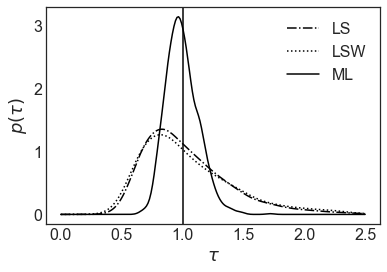

In [9]:
# decay time KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0,2.5,200)
densityLS = gaussian_kde(result_array.T[0])
densityLSW = gaussian_kde(result_array.T[6])
densityML = gaussian_kde(result_Bayes_array.T[2])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.savefig("tau_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

/Users/hstrey/miniconda3/envs/pymc3_2/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hstrey/miniconda3/envs/pymc3_2/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/Users/hstrey/miniconda3/envs/pymc3_2/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


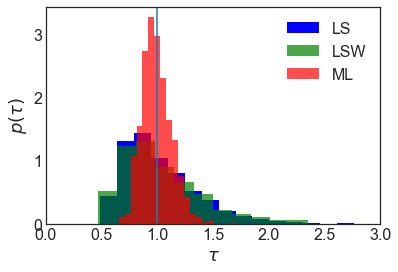

In [10]:
# decay time
plt.figure(facecolor="white")
plt.hist(result_array.T[0],normed=True,bins=20,label="LS",color="blue")
plt.hist(result_array.T[6],normed=True,alpha=0.7,bins=20,label="LSW",color="green")
plt.hist(result_Bayes_array.T[2],normed=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.xlim((0,3))
plt.savefig("tau_dist300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [11]:
phi = 1/result_array.T[3]
theta = 1/result_array.T[1]
omega = 1/result_array.T[4]
dA = np.sqrt(-theta/(phi*theta-omega**2))
dT = np.sqrt(-phi/(phi*theta-omega**2))*delta_t

phiW = 1/result_array.T[9]
thetaW = 1/result_array.T[7]
omegaW = 1/result_array.T[10]
dAW = np.sqrt(-theta/(phi*theta-omega**2))
dTW = np.sqrt(-phi/(phi*theta-omega**2))*delta_t

In [12]:
print("Decay time LS mean (real):",result_array.T[0].mean())
print("Decay time LS std (real):",result_array.T[0].std())
print("Decay time LS stderr (real):",result_array.T[0].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[0].mean()-1)/result_array.T[0].std()*np.sqrt(N))
print("Decay time LS std (fit):",(np.sqrt(result_array.T[1])*delta_t).mean())
print("Decay time LS std (fit corrected):",dT.mean())
print("Decay time LSW mean (real):",result_array.T[5].mean())
print("Decay time LSW std (real):",result_array.T[5].std())
print("Decay time LSW stderr (real):",result_array.T[5].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[5].mean()-1)/result_array.T[5].std()*np.sqrt(N))
print("Decay time LSW std (fit):",np.sqrt(result_array.T[6]*delta_t).mean())
print("Decay time LSW std (fit corrected):",dTW.mean())
print("Decay time Bayes mean (real):",result_Bayes_array.T[2].mean())
print("Decay time Bayes std (real):",result_Bayes_array.T[2].std())
print("Decay time Bayes stderr (real):",result_Bayes_array.T[2].std()/np.sqrt(N))
print("Decay time Bayes std (fit):",result_Bayes_array.T[3].mean())

Decay time LS mean (real): 1.0511330280624347
Decay time LS std (real): 0.3905818920277206
Decay time LS stderr (real): 0.0039058189202772057
Decay time (mean-true)/stderr: 13.091499914902776
Decay time LS std (fit): 0.00011450259084103781
Decay time LS std (fit corrected): 0.000113979437567719
Decay time LSW mean (real): 1.953151405981036
Decay time LSW std (real): 2.062856350876919
Decay time LSW stderr (real): 0.020628563508769193
Decay time (mean-true)/stderr: 46.20541830631357
Decay time LSW std (fit): 0.10150797451666932
Decay time LSW std (fit corrected): 0.000113979437567719
Decay time Bayes mean (real): 0.9971927568886603
Decay time Bayes std (real): 0.13307109625094737
Decay time Bayes stderr (real): 0.0013307109625094737
Decay time Bayes std (fit): 0.141744498927101


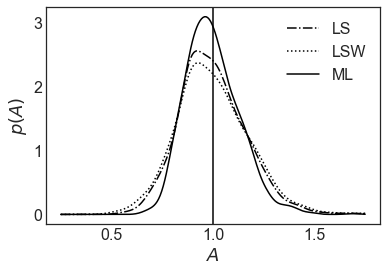

In [13]:
# amplitude KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0.25,1.75,200)
densityLS = gaussian_kde(result_array.T[2])
densityLSW = gaussian_kde(result_array.T[8])
densityML = gaussian_kde(result_Bayes_array.T[0])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")
plt.savefig("A_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

/Users/hstrey/miniconda3/envs/pymc3_2/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/Users/hstrey/miniconda3/envs/pymc3_2/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hstrey/miniconda3/envs/pymc3_2/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


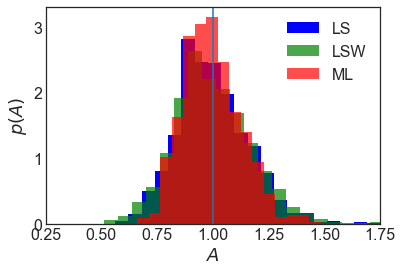

In [14]:
# amplitude
plt.hist(result_array.T[2],normed=True,bins=20,label="LS",color="blue")
plt.hist(result_array.T[8],normed=True,alpha=0.7,bins=20,label="LSW",color="green")
plt.hist(result_Bayes_array.T[0],normed=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")

plt.xlim((0.25,1.75))
plt.savefig("A_dist300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [15]:
print("Amplitude LS mean (real):",result_array.T[2].mean())
print("Amplitude LS std (real):",result_array.T[2].std())
print("Amplitude LS stderr (real):",result_array.T[2].std()/np.sqrt(N))
print("Amplitude LS std (fit):",np.sqrt(result_array.T[3]).mean())
print("Amplitude LS std (fit corrected):",dA.mean())
print("Amplitude LSW mean (real):",result_array.T[7].mean())
print("Amplitude LSW std (real):",result_array.T[7].std())
print("Amplitude LSW stderr (real):",result_array.T[7].std()/np.sqrt(N))
print("Amplitude LSW std (fit):",np.sqrt(result_array.T[8]).mean())
print("Amplitude LSW std (fit corrected):",dAW.mean())
print("Amplitude Bayes mean (real):",result_Bayes_array.T[0].mean())
print("Amplitude Bayes std (real):",result_Bayes_array.T[0].std())
print("Amplitude Bayes std (fit):",result_Bayes_array.T[1].mean())

Amplitude LS mean (real): 0.9984105682703185
Amplitude LS std (real): 0.16181660243234747
Amplitude LS stderr (real): 0.0016181660243234748
Amplitude LS std (fit): 1.6478751794738906
Amplitude LS std (fit corrected): 1.6578702573632431
Amplitude LSW mean (real): 0.0002714528255314531
Amplitude LSW std (real): 0.00034691485586727563
Amplitude LSW stderr (real): 3.4691485586727565e-06
Amplitude LSW std (fit): 0.9950832668680414
Amplitude LSW std (fit corrected): 1.6578702573632431
Amplitude Bayes mean (real): 0.9974432559467948
Amplitude Bayes std (real): 0.13182747665608338
Amplitude Bayes std (fit): 0.1410535876226702


(1000, 12)
(1000, 4)
(0.3183106738638477, 5.5484464485969005e-25)


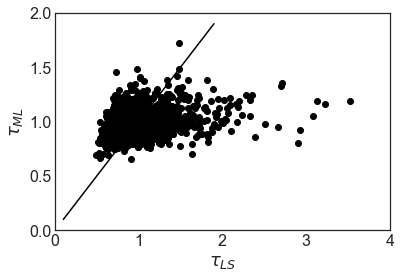

In [16]:
#decay correlation
print(result_array.shape)
print(result_Bayes_array.shape)
plt.scatter(result_array.T[0],result_Bayes_array.T[2],color="k")
plt.plot([0.1,1.9],[0.1,1.9],"k")
plt.xlim((0,4))
plt.ylim((0,2))
plt.xlabel(r'$\tau_{LS}$')
plt.ylabel(r'$\tau_{ML}$')
print(pearsonr(result_array.T[0],result_Bayes_array.T[2]))
plt.savefig("tau_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(0.8370114347767421, 1.3727086902429519e-263)


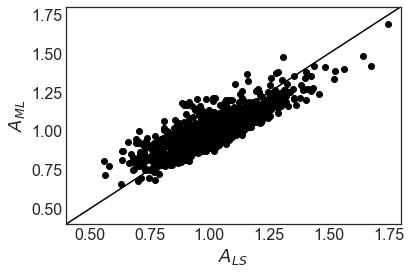

In [17]:
# amplitude correlation
plt.scatter(result_array.T[2],result_Bayes_array.T[0],color="k")
plt.plot([0,1.8],[0,1.8],"k")
plt.xlim((0.4,1.8))
plt.ylim((0.4,1.8))
plt.xlabel(r'$A_{LS}$')
plt.ylabel(r'$A_{ML}$')
print(pearsonr(result_array.T[2],result_Bayes_array.T[0]))
plt.savefig("A_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [18]:
for i,a,da,t,dt in zip(range(len(result_array.T[2])),result_array.T[2],dA,result_array.T[0],dT):
    print(i,a,da,t,dt)

0 0.808615696056012 0.9520460345979704 0.9939418654806541 5.44211158822298e-05
1 0.7384507401780944 4.862577555746134 1.659481283174133 0.0001480077515543126
2 0.8189945390255113 1.7689000724257453 1.2161571144605954 8.34126965096077e-05
3 1.177426213439023 0.8946273247059087 0.869670623699744 8.512380556837136e-05
4 1.0437891737470233 1.2763371773673646 0.6674355511975543 0.00014007021533873082
5 0.883051617048809 1.028418417380065 0.7431840677695469 8.582190529365809e-05
6 0.9986686993248759 0.61485594985586 0.8289406605407509 5.205087905933228e-05
7 0.8705609103632095 1.5361640341763998 1.2761723469792459 7.324202103499731e-05
8 1.0469415961904982 0.7094509812806725 1.0666728821039506 4.889410637600743e-05
9 0.8705229773500358 1.1921526795272193 1.404644623697107 5.136756260122944e-05
10 1.210331143970472 1.6411396323246221 0.6449979054220899 0.00021603434174906265
11 1.0678373545348654 2.633043239929993 1.5898917788383589 0.00012159441384276045
12 1.0466327034058365 3.0249401391300

653 0.7229771529627782 1.504994145349036 1.1408442879115908 6.690144475775965e-05
654 0.9936219950470155 0.6700783508067424 0.8642170549210936 5.414179861089583e-05
655 0.9240406108029715 0.5327163680617351 1.045521047963906 3.3068655849660885e-05
656 1.0419611587831445 0.881444090643387 0.6016159816963211 0.00010706304584901134
657 1.3796906367257336 1.609135223724567 0.701316109097676 0.00022228362633943793
658 1.0016502579041822 1.6903271106434512 0.6052074257861851 0.00019615638704084594
659 0.8068790536838826 2.2567273516779154 1.209396393375598 0.00010544949008825955
660 0.8448943450381698 0.818731340133432 0.5985731767133358 8.104959206695895e-05
661 1.425040936832656 1.40687801472775 0.8211897195886859 0.00017156454556700168
662 0.9792009851114964 1.137703310345424 0.6683429612381256 0.000116991418063971
663 1.1043645708874874 1.1202964241582547 0.815656013010224 0.0001065896085481309
664 1.0718439886361044 1.801984432299098 0.8307712651697817 0.00016335585043170884
665 1.01016

In [19]:
n=209
acf = acf_all[n]
t = np.arange(len(acf))*delta_t
fit = result_array.T[2][n]*np.exp(-t/result_array.T[0][n])
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2)))
print(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2/np.log(10))
print(1/np.sqrt(2*np.pi))
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2)))
print(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2/np.log(10))
print(acf.shape)

2.66E-01
-0.1768065739727682
0.3989422804014327
0.00E+00
-84750898.99543495
(500,)


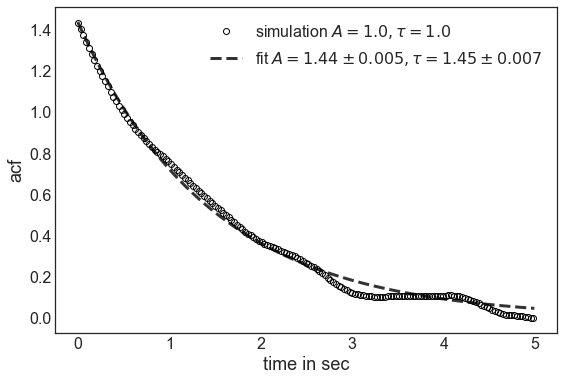

In [20]:
plt.figure(figsize=(9,6))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="k",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t,fit,"k--",linewidth=3,label=r"fit $A=1.44\pm0.005,\tau=1.45\pm0.007$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
plt.savefig("exp_fit300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [21]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep', 'arviz-colors', 'arviz-white', 'arviz-whitegrid', 'arviz-darkgrid']


In [22]:
# plot deviation from true D as function of N
Nsim = np.array([2000,10000,50000])
Nsimfit = np.array([1500,10000,60000])
dD = np.array([0.36,0.05,0.014])

(0.005, 1)

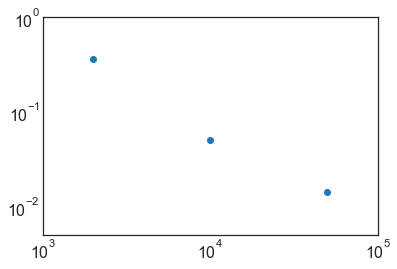

In [23]:
plt.plot(Nsim,dD,"o")
plt.xscale('log')
plt.yscale('log')
plt.xlim((1000,100000))
plt.ylim((0.005,1))

In [24]:
lnNsim = np.log(Nsim)
lndD = np.log(dD)

In [25]:
p = np.polyfit(lnNsim,lndD,1)

In [26]:
# dD = A*Nsim**gamma
# ln dD = ln A + gamma*ln Nsim
dDfit = np.exp(p[1])*Nsimfit**p[0]

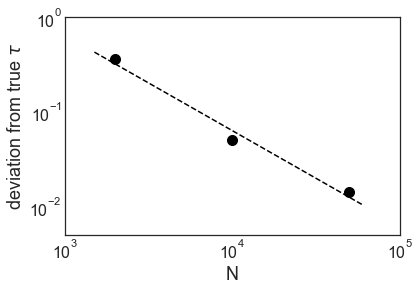

In [27]:
plt.plot(Nsim,dD,"ko",markersize=10)
plt.plot(Nsimfit,dDfit,"k--")
plt.xscale('log')
plt.yscale('log')
plt.xlim((1000,100000))
plt.ylim((0.005,1))
plt.xlabel("N")
plt.ylabel(r"deviation from true $\tau$")
plt.savefig("deviation.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1594.00draws/s]
The acceptance probability does not match the target. It is 0.7140415505004655, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/hstrey/miniconda3/envs/pymc3_2/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
A,1.448812,0.020220,0.000159,1.409821,1.489007,15304.074596,0.999997
tau,1.444035,0.025075,0.000189,1.394059,1.492182,15762.691875,0.999986


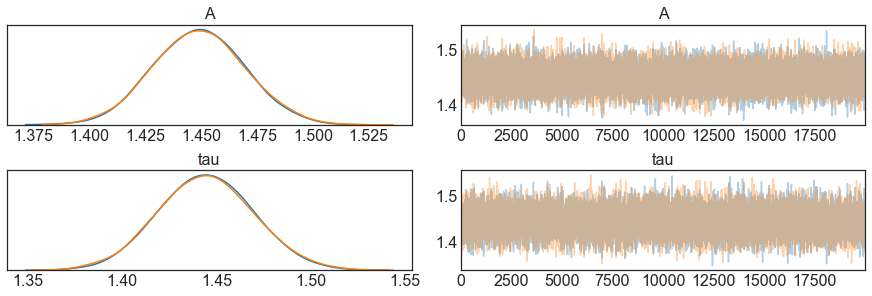

In [36]:
with pm.Model() as model:
    A = pm.Uniform('A', lower=0, upper=50)
    tau = pm.Uniform('tau', lower=0, upper=50)

    likelihood = pm.Normal('likelihood', mu=A*pm.math.exp(-t/tau),tau=1/acf_std**2,observed=acf)
    
    trace = pm.sample(20000,tune=10000)
    
pm.traceplot(trace)
pm.summary(trace)

[1.4096029  1.42834623 1.43499104 1.44872199 1.46237863 1.46912489
 1.48887264]
[1.39535518 1.41872199 1.42697112 1.44381966 1.46090353 1.46908817
 1.49366035]
A_sigma 0.020389332150647643
tau_sigma 0.02518308776686129


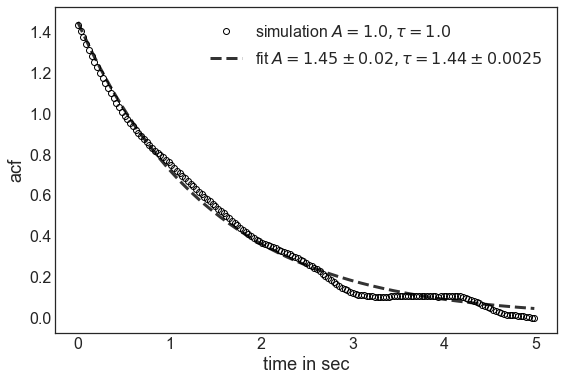

In [38]:
A_perc= np.percentile(trace['A'],[2.5,15.865,25,50,75,84.135,97.5])
tau_perc=np.percentile(trace['tau'],[2.5,15.865,25,50,75,84.135,97.5])
print(A_perc)
print(tau_perc)
print('A_sigma',(A_perc[5]-A_perc[1])/2)
print('tau_sigma',(tau_perc[5]-tau_perc[1])/2)
plt.figure(figsize=(9,6))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="k",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t[::3],trace['A'].mean()*np.exp(-t[::3]/trace['tau'].mean()),"k--",linewidth=3,label=r"fit $A=1.45\pm0.02,\tau=1.44\pm0.0025$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
#plt.savefig("exp_fit300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

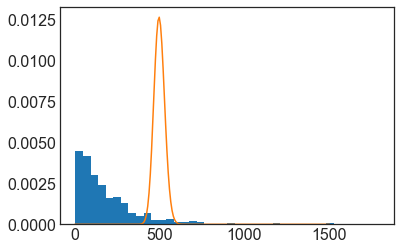

In [32]:
# lets look at the chi^2 distribution of the least-square fit
x=np.linspace(0,1500,200)
chi2dist = chi2.pdf(x,500-2)
plt.hist(result_array.T[11],bins=40,density=True)
plt.plot(x,chi2dist)

In [33]:
result_array.T[11].mean()

192.78086697829272

In [34]:
# use mcmc for all fits
mcmc_results = None

for i,y in enumerate(acf_all):
    with pm.Model() as model:
        A = pm.Uniform('A', lower=0, upper=50)
        tau = pm.Uniform('tau', lower=0, upper=50)

        likelihood = pm.Normal('likelihood', mu=A*pm.math.exp(-t/tau),tau=1/acf_std**2,observed=y)
    
        trace = pm.sample(20000,tune=10000)
    A_perc= np.percentile(trace['A'],[2.5,15.865,25,50,75,84.135,97.5])
    tau_perc=np.percentile(trace['tau'],[2.5,15.865,25,50,75,84.135,97.5])
    print(A_perc)
    print(tau_perc)
    A_sigma = (A_perc[5]-A_perc[1])/2
    tau_sigma = (tau_perc[5]-tau_perc[1])/2
    A_med = A_perc[3]
    tau_med = tau_perc[3]
    if mcmc_results is None:
        mcmc_results = np.array([A_med,tau_med,A_sigma,tau_sigma])
    else:
        mcmc_results = np.vstack((mcmc_results,np.array([A_med,tau_med,A_sigma,tau_sigma])))




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:41<00:00, 1450.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:46<00:00, 1282.03draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:43<00:00, 1381.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:45<00:00, 1329.17draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains:

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:41<00:00, 1449.37draws/s]
The acceptance probability does not match the target. It is 0.6646874736844178, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:43<00:00, 1379.26draws/s]
The acceptance probability does not match the target. It is 0.8947101697007364, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:42<00:00, 1422.65draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sa

Sampling 2 chains: 100%|██████████| 60000/60000 [00:41<00:00, 1443.62draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:48<00:00, 1235.82draws/s]
The acceptance probability does not match the target. It is 0.5335481466243612, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7021171315352537, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:41<00:00, 1448.68draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NU

Sampling 2 chains: 100%|██████████| 60000/60000 [00:39<00:00, 1533.82draws/s]
The acceptance probability does not match the target. It is 0.880450407102653, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1603.24draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1655.43draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1658.79draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target

Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1616.78draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1646.61draws/s]
The acceptance probability does not match the target. It is 0.7143656110280159, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:38<00:00, 1578.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1637.97draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1620.34draws/s]
The acceptance probability does not match the target. It is 0.8945698165626842, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:35<00:00, 1681.97draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:38<00:00, 1578.38draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1635.22draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1643.82draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:44<00:00, 1336.29draws/s]
The acceptance probability does not match the target. It is 0.9002028740581621, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:39<00:00, 1514.47draws/s]
The acceptance probability does not match the target. It is 0.9040530550858074, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:39<00:00, 1503.10draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1655.94draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1635.80draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1623.08draws/s]
The acceptance probability does not match the target. It is 0.7017945240272826, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1650.78draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:35<00:00, 1700.18draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1649.86draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1651.34draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1659.57draws/s]
Auto-assigning N

Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1656.83draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1644.65draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:39<00:00, 1500.94draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1589.08draws/s]
The acceptance probability does not match the target. It is 0.6836771935380961, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:38<00:00, 1562.44draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:35<00:00, 1683.66draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:38<00:00, 1570.84draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1654.10draws/s]
The acceptance probability does not match the target. It is 0.64586660983016, but should be close to 0.8. Try to increase the number of tuning steps.
Au

Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1628.93draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:39<00:00, 1521.90draws/s]
The acceptance probability does not match the target. It is 0.7154035710110832, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:38<00:00, 1559.37draws/s]
The acceptance probability does not match the target. It is 0.8876693708129113, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1588.34draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:35<00:00, 1694.21draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1606.17draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1632.37draws/s]
The acceptance probability does not match the target. It is 0.7189017699993739, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1646.22draws/s]
The acceptance probability does not match the target. It is 0.6939840460672803, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:38<00:00, 1565.97draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1645.18draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:35<00:00, 1671.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1642.02draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:35<00:00, 1689.23draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1603.64draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:35<00:00, 1700.97draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1604.86draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1602.80draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:38<00:00, 1552.57draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1650.19draws/s]
The acceptance probability does not match the target. It is 0.8848571823500089, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1639.50draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:38<00:00, 1547.14draws/s]
The acceptance probability does not match the target. It is 0.8991025449293142, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:35<00:00, 1697.07draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:38<00:00, 1571.68draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]


Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1625.15draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1643.45draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:43<00:00, 1372.85draws/s]
The acceptance probability does not match the target. It is 0.886911428418396, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1581.55draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
S

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:38<00:00, 1573.94draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1609.79draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1631.33draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1662.54draws/s]
The acceptance probability does not match the target. It is 0.6531636436883762, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:35<00:00, 1670.48draws/s]
The acceptance probability does not match the target. It is 0.6366917636389349, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1628.60draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1624.16draws/s]
The acceptance probability does not match the target. It is 0.6626233262532573, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6929176096067597, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1639.37draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:38<00:00, 1544.55draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:39<00:00, 1534.93draws/s]
The acceptance probability does not match the target. It is 0.8957227745676979, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:35<00:00, 1690.53draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1663.64draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1619.68draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1657.38draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:39<00:00, 1524.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1633.02draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag..

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1604.93draws/s]
The acceptance probability does not match the target. It is 0.9049112382429755, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:38<00:00, 1557.69draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1591.68draws/s]
The acceptance probability does not match the target. It is 0.5618032191354025, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitte

NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1586.80draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:38<00:00, 1563.22draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:38<00:00, 1552.38draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1660.72draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1593.31draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitt

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1610.08draws/s]
The acceptance probability does not match the target. It is 0.7215916903181487, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1612.80draws/s]
The acceptance probability does not match the target. It is 0.7048761429436214, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:35<00:00, 1679.63draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sa

NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1625.85draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1641.78draws/s]
The acceptance probability does not match the target. It is 0.6920363282588925, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1593.85draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1608.89draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)


Sampling 2 chains: 100%|██████████| 60000/60000 [00:38<00:00, 1543.22draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1619.41draws/s]
The acceptance probability does not match the target. It is 0.5613506717531661, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1636.95draws/s]
The acceptance probability does not match the target. It is 0.5901517798352721, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:38<00:00

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:43<00:00, 1394.49draws/s]
The acceptance probability does not match the target. It is 0.8917993332903508, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1609.12draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1629.50draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:35<00:00, 1685.77draws/s]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1619.35draws/s]
The acceptance probability does not match the target. It is 0.5754326805804872, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1642.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:41<00:00, 1448.83draws/s]
The acceptance probability does not match the target. It is 0.7039353245363613, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitte

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:38<00:00, 1539.09draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1633.19draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1616.58draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1606.99draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1661.64draws/s]
Auto-assigning N

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1624.57draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1584.93draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1606.19draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1613.34draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:46<00:00, 1283.31draws/s]
Auto-assigning N

Sampling 2 chains: 100%|██████████| 60000/60000 [00:38<00:00, 1538.49draws/s]
The acceptance probability does not match the target. It is 0.7099757518338103, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1638.32draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1649.34draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1583.70draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1608.42draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:36<00:00, 1645.09draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:37<00:00, 1600.51draws/s]
The acceptance probability does not match the target. It is 0.7131909250350758, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, A]
Sampling 2 chains: 100%|██████████| 60000/60000 [00:38<00:00, 1551.16draws/s]
The acceptance probability does not match the target. It is 0.89878581180812

(0.9, 1.1)

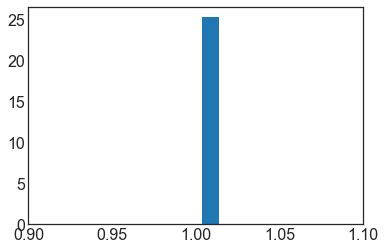

In [43]:
_=plt.hist(mcmc_results[0],bins=100,density=True)
plt.xlim((0.9,1.1))